# On meta-learning optimizers

In this notebook, we give a thorough description of the theory underlying meta-learning optimization networks. This allows us to construct output exxpectations for our meta-learning systems that can, in turn, be used to validate the implementation. 

The idea behind meta-learning optimizers is to replace hand-crafted optimizers (e.g., SGD, Adam) by neural networks that can learn how to optimize the weights of another neural network, called the *base-learner*.

## Base- and meta- networks
In the rest of this notebook, we will assume that our base-learner and meta-learner networks are given below:

<img src="images/turtlexample.png">

Here, our base-learner is a regression neural network with a single input and output nodes. It takes inputs $x \in \mathbb{R}$, and returns predictions $\hat{y} = wx \in \mathbb{R}$.
Instead of training this model using common techniques such as SGD or Adam, we will use a meta-learner network. In this case, our meta-learner takes a single input, namely the gradient of the loss function with respect to the base-learner parameter $w$, i.e., $\nabla_w \in \mathbb{R}$. As output, it gives a proposed weight update $u = m\nabla_w \in \mathbb{R}$.

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseLearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.autograd.Variable(torch.ones(1,1), requires_grad=True)

    def forward(self, x):
        return F.linear(input=x, weight=self.w)
    
    def forward_weight(self, x, w):
        return F.linear(input=x, weight=w)


class MetaLearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = nn.Parameter(-0.01* torch.ones(1,1))
        
    def forward(self, x):
        return F.linear(input=x, weight=self.m)
    

## How does it work?

Assume that we have a single task. A task consists of a *support set* and *query set*. The support set can be seen as training data, and the query set as validation data. For simplicity, we assume that our task looks as follows:

- Support set: Input $x_{tr} \in \mathbb{R}$ with output $y_{tr} \in \mathbb{R}$
- Query set: Input $x_{te} \in \mathbb{R}$ with output $y_{te} \in \mathbb{R}$

Lastly, assume that we want our base-learner network to minimize the MSE loss function $\mathcal{L}(y, \hat{y}) = (y - \hat{y}(w))^2$.


Normally, we would perform the following steps:
1. Randomly initialize base-learner weights $w_0$ 
2. For epoch = 0,...,T-1:
    1. Compute loss on train set $\mathcal{L}(y_{tr}, \hat{y}_{tr}(w_{t}))$
    2. Update the base-learner parameters (compute $w_{t+1}$) with SGD or Adam using $\nabla_{w_{t}} \mathcal{L}(y_{tr}, \hat{y}_{tr}(w_{t}))$

In our meta-learning context, however, we replace SGD or Adam in step B by our meta-learning network. Also, since we introduce a trainable network, we will have to add a few steps to update our meta-learner network.

1. Randomly initialize base- and meta-learner weights $w_0$ and $m_0$
2. For epoch = 0,...,T-1:
    1. Compute loss on train set $\mathcal{L}(y_{tr}, \hat{y}_{tr}(w_t))$
    2. Compute weight update by feeding the loss gradient $\nabla_w \mathcal{L}(y_{tr}, \hat{y}_{tr}(w_t))$ into our meta-learner network. Update the weights using $w_{t+1} := w_t + m\nabla_{w_{t}}\mathcal{L}(y_{tr}, \hat{y}_{tr}(w_t))$
3. Update the meta-learner parameters with SGD or Adam using $\nabla_m \mathcal{L}(y_{te} - \hat{y}_{te}(w_T))^2$


Thus, instead of updating our base-learner with hand-crafted rules (as SGD or Adam), we feed the gradient into our meta-learning network, which then computes weight updates for our base-learner! After updating the base-learner for a fixed number of steps $T$, we compute the loss on the validation/test set $(x_{te}, y_{te})$ in order to update our meta-learner network. Note that the latter is performed with hand-crafted rules such as SGD or Adam.

## The mathematics behind this for first-order TURTLE

Now it is time to investigate the precise form of the base- and meta-learner weight updates. Suppose our support and query sets are generated by a true function $f : \mathbb{R} \rightarrow \mathbb{R}$, where $f(x) = 2x + 1$. Furthermore, we assume that we make two updates to our base-learner per task, i.e., $T = 2$.

Lastly, suppose our task looks as follows:
- Support set: $x_{tr} = 2$ with $y_{tr}=2 \times 2 + 1 = 5$
- Query set: $x_{te} = 4$ with $y_{te} = 2 \times 4 + 1 = 9$ 

We now work through the entire procedure for 2 updates. First in abstract form. Then, using our numerical example.

### Abstract

**Step t = 0**

We compute the training loss with our initial weights $w_0$, giving us $\mathcal{L}(y_{te}, \hat{y}_{te}(w_0))$.
We compute the derivative of this loss with respect to our base-learner parameter $w_0$, which gives us $\frac{\partial}{\partial w_0} \mathcal{L}(y_{te}, \hat{y}_{te}(w_0))$. 
This derivative is fed into our meta-learner network, which gives us a weight update $u_0 = m_0 \frac{\partial}{\partial w_0} \mathcal{L}(y_{te}, \hat{y}_{te}(w_0))$. 
Finally, we compute $w_1 = w_0 + u_0 = w_0 + m_0 \frac{\partial}{\partial w_0} \mathcal{L}(y_{te}, \hat{y}_{te}(w_0))$.

**Step t = 1**

With our new weights $w_1$, we compute $\mathcal{L}(y_{tr} - \hat{y}_{tr}(w_1))$, and the derivative of this loss with respect to our base-learner parameter $w_1$, i.e., $\frac{\partial}{\partial w_1} \mathcal{L}(y_{tr} - \hat{y}_{tr}(w_1))$. 
This is fed into the meta-learner network, which computes update $u_2 = m \frac{\partial}{\partial w_1} \mathcal{L}(y_{tr} - \hat{y}_{tr}(w_1))$. We use this update to compute $w_2 = w_1 + u_1 = w_1 + m \frac{\partial}{\partial w_1} \mathcal{L}(y_{tr} - \hat{y}_{tr}(w_1))$.


**Updating the meta-learner**

We now need to compute updates for our meta-learner network, such that it can improve its ability to update the base-learner. We do this by first measuring its current performance (how well did it update the base-learner) on the validation/test set $(x_{te}, y_{te})$. 
Then, we compute the gradient of this loss with respect to the meta-learner parameters to update them using regular optimization techniques such as as SGD or Adam. 

Thus, we begin by computing $\mathcal{L}(y_{te}, \hat{y}_{te}(w_2))$ and $\frac{\partial}{\partial m} \mathcal{L}(y_{te}, \hat{y}_{te}(w_2))$. Suppose we use SGD with learning rate $\alpha$. Then, meta-parameter $m$ would be updated as $m' = m - \alpha \frac{\partial}{\partial m} \mathcal{L}(y_{te}, \hat{y}_{te}(w_2))$. 

### Numerical example

Suppose we initialize $w=1$ and $m=-0.01$. 

**Step t = 0**
1. Loss on the train set is $\mathcal{L}(y_{tr}, \hat{y}_{tr}(w_0)) = (y_{tr} - \hat{y}_{tr}(w_0))^2 = (y_{tr} - w_0x_{tr})^2 =  (5 - 2)^2 = 9$.
2. The partial derivative with respect to $w_0$ is given by $\frac{\partial}{\partial w_0} (y_{tr} - w_0x_{tr})^2 = -2(y_{tr} - w_0x_{tr}) \cdot x_{tr} = -4(5 - 2) = -12$.
3. We feed this partial derivative into meta-learner network, to get update $u_0 = m \frac{\partial}{\partial w_0} (y_{tr} - w_0x_{tr})^2 = -0.01 \cdot -12 = 0.12$
4. We compute new base-learner weights $w_1 = w_0 + u_0 = 1 + 0.12 = 1.12$.

**Step t = 1**
1. Compute $\mathcal{L}(y_{tr}, \hat{y}_{tr}(w_1)) = (y_{tr} - \hat{y}_{tr}(w_1))^2 = (y_{tr} - w_1x_{tr})^2 =  (5 - 1.12 \cdot 2)^2 = 2.76^2 = 7.6176$.
2. Compute the derivative w.r.t. $w_1$, i.e., $\frac{\partial}{\partial w_1} (y_{tr} - w_1x_{tr})^2 = -2(y_{tr} - w_1x_{tr}) \frac{\partial}{\partial w_1} w_1x_{tr} = -2(y_{tr} - w_1x_{tr}) x_{tr} = -4(5 - 1.12 \cdot 2) = -4 \times 2.76 = -11.04$.
3. Feed thid derivative as input to the meta-learner network to get update $u_1 = m \frac{\partial}{\partial w_1} (y_{tr} - w_1x_{tr})^2 = -11.04 m = -11.04 \times -0.01 = 0.1104$.
4. Compute new base-learner weights $w_2 = w_1 + u_1 = 1.12 + 0.1104 = 1.2304$

**Updating the meta-learner**
1. Compute the base-learner loss with the new weights on the *test set*: $\mathcal{L}(y_{te}, \hat{y}_{te}(w_2)) = (y_{te} - \hat{y}_{te}(w_2))^2$. 
2. Compute the derivative of this loss w.r.t. the meta-learner parameter $m$, i.e., $\frac{\partial}{\partial m} (y_{te} - \hat{y}_{te}(w_2))^2 = -2(y_{te} - \hat{y}_{te}(w_2)) \frac{\partial}{\partial m} \hat{y}_{te}(w_2) = -2(y_{te} - \hat{y}_{te}(w_2)) \frac{\partial}{\partial m} w_2x_{te} = -2(y_{te} - \hat{y}_{te}(w_2)) \frac{\partial}{\partial m} (w_0 + u_0 + u_1)x_{te} = -2(y_{te} - \hat{y}_{te}(w_2)) \frac{\partial}{\partial m} (w_0 + m \frac{\partial}{\partial w_0} (y_{tr} - w_0x_{tr})^2 + m \frac{\partial}{\partial w_1} (y_{tr} - w_1x_{tr})^2)x_{te} = 
-2(y_{te} - \hat{y}_{te}(w_2)) (\frac{\partial}{\partial w_0} (y_{tr} - w_0x_{tr})^2 + \frac{\partial}{\partial w_1} (y_{tr} - w_1x_{tr})^2)x_{te} = -8(9 - 1.2304 \cdot 4) (-12 - 11.04) = -8 \times 4.0784 \times - 23.04  \approx 751.730688$.

Gradient: -12.0
Update: tensor([[0.1200]], grad_fn=<MmBackward>)
Loss at t=0: 9.0
New weight: 1.1200000047683716
Gradient: -11.039999961853027
Update: tensor([[0.1104]], grad_fn=<MmBackward>)
Loss at t=1: 7.617599964141846
New weight: 1.2303999662399292
Test loss: 16.63334846496582
Meta-learner gradient: 751.730712890625


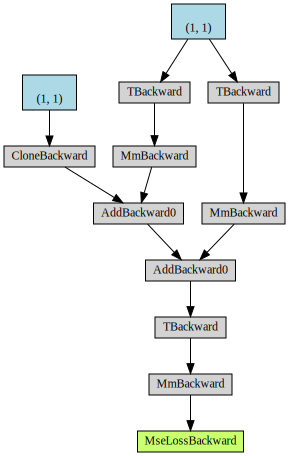

In [5]:
from torchviz import make_dot

np.random.seed(0)
torch.manual_seed(0)

# Construct base- and meta-learner networks
baselearner = BaseLearner()
metalearner = MetaLearner()

# Support and query set
x_train, y_train = torch.zeros(1,1)+2, torch.zeros(1,1) + 5 # support set
x_test, y_test = torch.zeros(1,1)+4, torch.zeros(1,1)+9 # query set

init = baselearner.w.clone().detach()
init.requires_grad=True
m = metalearner.m

w = init.clone()
w.retain_grad()
loss = nn.MSELoss()

for t in range(2):
    # Compute loss with current weight w
    preds = baselearner.forward_weight(x_train, w)
    train_loss = loss(preds, y_train)
    grad = torch.autograd.grad([train_loss], [w], retain_graph=True, create_graph=False)[0]
    print("Gradient:", grad.item())
    # Compute update proposed by meta-learner
    updt = metalearner(grad)
    
    w = w + updt
    w.retain_grad()
    
    print("Update:", updt)
    
    print(f"Loss at t={t}:", train_loss.item())
    print(f"New weight: {w.item()}")

#m.grad.zero_()
tpred = baselearner.forward_weight(x_test, w)
test_loss = loss(tpred, y_test)
test_loss.backward()

print("Test loss:", test_loss.item())
print("Meta-learner gradient:", m.grad.item())
make_dot(test_loss)

#### Second-order TURTLE

Initialization gradient: -27.615663528442383
Meta-learner gradient: 720.4085693359375


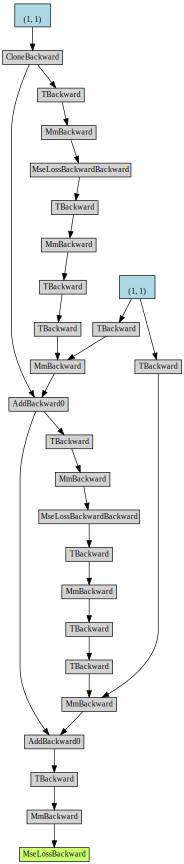

In [27]:
from torchviz import make_dot

np.random.seed(0)
torch.manual_seed(0)

# Construct base- and meta-learner networks
baselearner = BaseLearner()
metalearner = MetaLearner()

# Support and query set
x_train, y_train = torch.zeros(1,1)+2, torch.zeros(1,1) + 5 # support set
x_test, y_test = torch.zeros(1,1)+4, torch.zeros(1,1)+9 # query set

init = baselearner.w.clone().detach()
init.requires_grad=True
m = metalearner.m

w = init.clone()
w.retain_grad()
loss = nn.MSELoss()

for t in range(2):
    preds = baselearner.forward_weight(x_train, w)
    train_loss = loss(preds, y_train)
    grad = torch.autograd.grad([train_loss], [w], create_graph=True)[0]
    #print("Gradient:", grad.item())
    updt = metalearner(grad)
    w = w + updt
    w.retain_grad()
    #print("Grad w.r.t. init:", torch.autograd.grad(w, init, retain_graph=True))
    #print("Grad w.r.t. m:", torch.autograd.grad(w, m, retain_graph=True))
    #print("Update:", - 0.01 * grad)
    #print(f"Loss at t={t}:", train_loss.item())
    #print(f"New weight: {w.item()}")

tpred = baselearner.forward_weight(x_test, w)
test_loss = loss(tpred, y_test)
test_loss.backward()
#print("Test loss:", test_loss.item())
print("Initialization gradient:", init.grad.item())
print("Meta-learner gradient:", m.grad.item())
make_dot(test_loss)

### Speed experiments

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseLearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.autograd.Variable(torch.ones(40,1) + torch.randn(40,1), requires_grad=True)
        self.w2 = torch.autograd.Variable(torch.ones(1,40) + torch.randn(1,40), requires_grad=True)
        
    def forward(self, x):
        x = F.linear(input=x, weight=self.w)
        return F.linear(input=x, weight=self.w2)
    
    def forward_weight(self, x, ws):
        x = F.linear(input=x, weight=ws[0])
        return F.linear(input=x, weight=ws[1])


class MetaLearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = nn.Parameter(-0.01* torch.ones(1,1))
        
    def forward(self, x):
        return F.linear(input=x, weight=self.m)
    

In [23]:
%%timeit
from torchviz import make_dot

np.random.seed(0)
torch.manual_seed(0)

# Construct base- and meta-learner networks
baselearner = BaseLearner()
metalearner = MetaLearner()

# Support and query set
x_train, y_train = torch.zeros(1,1)+2, torch.zeros(1,1) + 5 # support set
x_test, y_test = torch.zeros(1,1)+4, torch.zeros(1,1)+9 # query set

init = [baselearner.w.clone().detach(), baselearner.w2.clone().detach()]
for p in init:
    p.requires_grad=True
m = metalearner.m

w = [p.clone() for p in init]
for p in w:
    p.retain_grad()
loss = nn.MSELoss()

for t in range(2):
    preds = baselearner.forward_weight(x_train, w)
    train_loss = loss(preds, y_train)
    grad = torch.autograd.grad([train_loss], w, create_graph=True)
    
    for i in range(len(w)):
        updt = metalearner(grad[i].reshape(-1,1))
        w[i] = w[i] + torch.reshape(updt, w[i].size())
        
    for p in w:
        p.retain_grad()
    #print("Grad w.r.t. init:", torch.autograd.grad(w, init, retain_graph=True))
    #print("Grad w.r.t. m:", torch.autograd.grad(w, m, retain_graph=True))
    #print("Update:", - 0.01 * grad)
    #print(f"Loss at t={t}:", train_loss.item())
    #print(f"New weight: {w.item()}")

tpred = baselearner.forward_weight(x_test, w)
test_loss = loss(tpred, y_test)
test_loss.backward()
#print("Test loss:", test_loss.item())
#print("Initialization gradient:", init.grad.item())
#print("Meta-learner gradient:", m.grad.item())
make_dot(test_loss)

3.45 ms ± 54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
